In [1]:
import sys

sys.path.remove('/usr/local/lib/python3.9/site-packages')
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [2]:
import glob
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import mean_absolute_error
from PIL import Image, ImageDraw

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array

Using TensorFlow backend.


# Hyper params

In [3]:
PATCH_SIZE = 125
PATCH_MARGIN = PATCH_SIZE//2
CHANNEL_NUM = 3

SPACING = 40

# Methods

In [4]:
def cal_ndvi(img_r, img_ir):
    return (img_ir - img_r) / (img_ir + img_r + (1e-7)) # avoid zero division error

def cal_ndvi_norm(img_r, img_ir, r_factor, ir_factor):
    return (ir_factor*img_ir - r_factor*img_r) / (ir_factor*img_ir + r_factor*img_r + (1e-7))

def standarlization(img_2d):
    return (img_2d - np.min(img_2d)) / (np.max(img_2d) - np.min(img_2d))

def feature_extraction(img):
    if img.shape[0] == 7: # NDVI ensemble
        img_ndvi = np.mean(np.array([cal_ndvi(img[2], img[3]), cal_ndvi(img[4], img[5])]), axis=0)
    else:
        img_ndvi = cal_ndvi(img[2], img[3])
    img_vh = standarlization(img[0])
    img_vv = standarlization(img[1])
    img_elev = standarlization(img[-1])
    img_std = np.array([img_ndvi, img_vh, img_vv, img_elev])
    return img_std

def feature_extraction_norm(img, red_factor=0.83375, ir_factor=0.77875):
    if img.shape[0] == 7: # NDVI ensemble
        img_ndvi = np.mean(np.array([cal_ndvi_norm(img[2], img[3], red_factor, ir_factor), cal_ndvi_norm(img[4], img[5], red_factor, ir_factor)]), axis=0)
    else:
        img_ndvi = cal_ndvi_norm(img[2], img[3], red_factor, ir_factor)
    img_vh = standarlization(img[0])
    img_vv = standarlization(img[1])
    img_elev = standarlization(img[-1])
    img_std = np.array([img_ndvi, img_vh, img_vv, img_elev])
    return img_std

In [5]:
def generate_all_patch(img, SPACING=SPACING):
    
    h = img.shape[1]
    w = img.shape[2]
    
    num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
    num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
    
    img_std = feature_extraction(img)
#     img_std = feature_extraction_norm(img)
    
    all_patch = []

    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            img_extracted = img_std[:,start_h:end_h, start_w: end_w]
            all_patch.append(img_extracted)

    all_patch = np.array(all_patch)

    print(all_patch.shape)
    
    return all_patch


def generate_all_patch_from_input(img_std, SPACING=SPACING):
    
    h = img.shape[1]
    w = img.shape[2]
    
    num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
    num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
    
    all_patch = []

    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            img_extracted = img_std[:,start_h:end_h, start_w: end_w]
            all_patch.append(img_extracted)

    all_patch = np.array(all_patch)

    print(all_patch.shape)
    
    return all_patch


def patch_2_input(patch, scale=25):
    img_ndvi = patch[0]
    img_ndvi_coarse = drop_resolution(img_ndvi, scale)[0]
    X = np.array([img_ndvi_coarse, patch[1], patch[2], patch[3]])
    return X


def drop_resolution(img_1ch, scale=25):
    h, w = img_1ch.shape
    h_, w_ = h//scale, w//scale
    img_small = np.zeros((h_, w_))
    
    for i in range(h_):
        for j in range(w_):
            img_small[i, j] = np.mean(img_1ch[i*scale:(i+1)*scale, j*scale:(j+1)*scale])
            
    img_resized = img_small.repeat(scale, axis=0).repeat(scale, axis=1)
    return img_resized, img_small

In [6]:
def create_srcnn(channel_num=4):
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size= 9, activation='relu', padding='same', input_shape=(None,None,channel_num)))
    model.add(Conv2D(filters=32, kernel_size= 1, activation='relu', padding='same'))
    model.add(Conv2D(filters=1, kernel_size= 5, padding='same'))

    return model

# Prediction

## Sentinel-2 NDVI

In [140]:
city = 'oushu'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin/pixel_resized_/s2/*.npy')

for path in path_list:
    save_path = path.replace('pixel_resized_', 'pred')
    img = np.load(path).astype(np.float32)
    img_ndvi = cal_ndvi(img[2], img[3])
    np.save(save_path, img_ndvi)

## Modis NDVI

### Replace with bilinear DEM

In [142]:
dem_sen = np.load('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_0127.npy')[6]
# plt.imshow(dem_sen)

In [88]:
city = 'tsumagoi'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin/pixel_resized/*mod*.npy')
for path in path_list:
    img = np.load(path)
    img[-1] = dem_sen
    np.save(path, img)

### Generate patch

In [9]:
city = 'biei'
path_list = glob.glob(f'../sar_2_ndvi/{city}/modis/bin/pixel_resized/input/*mod*.npy')
for path in path_list:
    print(path)
    idx = path[-8:-4]
    
    img = np.load(path).astype(np.float32)
    
    patch_array = generate_all_patch_from_input(img)
    # patch_array = generate_all_patch(img)
    
    X_array = []
    for num, patch in enumerate(patch_array):
        X = patch_2_input(patch, scale=25)
        X_array.append(X)
        
    X_array = np.array(X_array).astype(np.float32).transpose(0,2,3,1)
        
    num = str(num).zfill(7)
    np.save(f'../sar_2_ndvi/{city}/modis/bin/patch_sr/input/X_{idx}.npy', X_array)

../sar_2_ndvi/biei/modis/bin/pixel_resized/input/collocate_mod_0602.npy
(1247, 4, 125, 125)
../sar_2_ndvi/biei/modis/bin/pixel_resized/input/collocate_mod_0415.npy
(1247, 4, 125, 125)
../sar_2_ndvi/biei/modis/bin/pixel_resized/input/collocate_mod_0930.npy
(1247, 4, 125, 125)


### Prediction

In [236]:
city = 'tsumagoi'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin_/patch_sr/input/X*.npy')

h = 573 # 930
w = 1016 # 720
num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
print(num_rows, num_cols)
channel_num = 3

model = create_srcnn(channel_num)
model.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_all_nodem_19/srcnn_4ch_nodem_all_250.h5')

for path in path_list:
    print(path)
    idx = path[-8:-4]
    
    X_array = np.load(path)[:,:,:,:channel_num]
    y_pred = model.predict(X_array)
    
    # Ensembling
    ens_h = PATCH_SIZE + SPACING*(num_rows-1)
    ens_w = PATCH_SIZE + SPACING*(num_cols-1)
    ens_array = np.zeros((ens_h, ens_w))
    count_array = np.zeros((ens_h, ens_w))
    y_count = np.ones(y_pred.shape)

    for index, (pred_patch, count_patch) in enumerate(zip(y_pred, y_count)):
        num_row = index // num_cols
        num_col = index % num_cols

        start_h = num_row*SPACING
        start_w = num_col*SPACING

        ens_array[start_h:start_h+PATCH_SIZE, start_w:start_w+PATCH_SIZE] += pred_patch.reshape((PATCH_SIZE, PATCH_SIZE))
        count_array[start_h:start_h+PATCH_SIZE, start_w:start_w+PATCH_SIZE] += count_patch.reshape((PATCH_SIZE, PATCH_SIZE))

    ens_array /= count_array
    
    np.save(f'../sar_2_ndvi/{city}/time_series/bin_/patch_sr/pred_past/pred_{idx}_mod.npy', ens_array)

11 22
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0303.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0115.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0103.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0315.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0502.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0514.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_1122.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0607.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0818.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0220.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0619.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_1110.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0408.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_0420.npy
../sar_2_ndvi/tsumagoi/time_series/bin_/patch_sr/input/X_1029.npy
../s

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0126_sen.npy


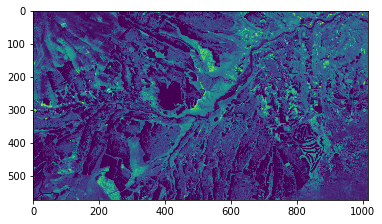

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0303_sen.npy


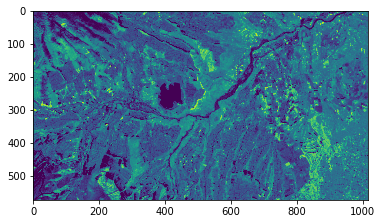

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0306_sen.npy


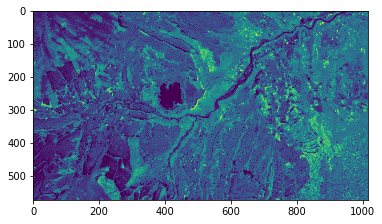

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0323_sen.npy


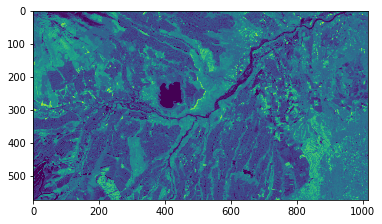

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0326_sen.npy


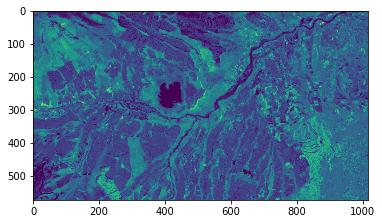

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0415_sen.npy


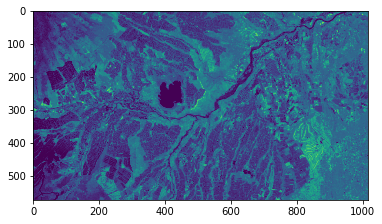

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0425_sen.npy


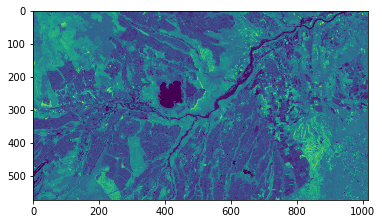

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0502_sen.npy


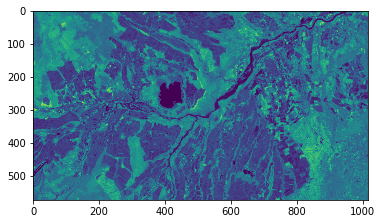

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0505_sen.npy


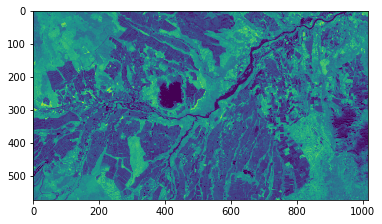

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0820_sen.npy


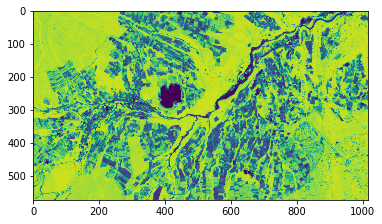

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_1002_sen.npy


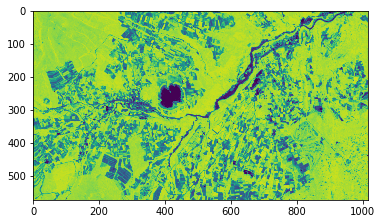

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_1108_sen.npy


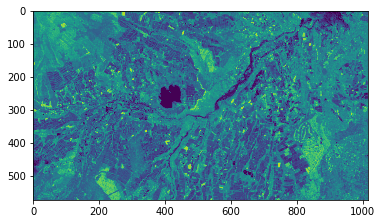

../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_1201_sen.npy


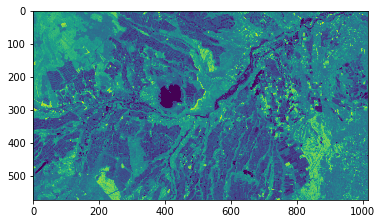

In [134]:
city = 'tsumagoi'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin_/pred_past/pred*sen*.npy')
path_list.sort()

for path in path_list:
    print(path)
    plt.imshow(np.load(path), vmin=0, vmax=1)
#     plt.axis('off')
    plt.show()

# Evaluation

## Oushu

In [208]:
city = 'oushu'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin/pred/*.npy')
path_list.sort()

# [300:500, 100:300][50:54, 75:79] -> [350:354, 175:179] # mountain
# [350:500, 400:550][60:64, 98:102] -> [410:414, 498:502]
# [600:750,150:300][16:20, 60:64] -> [616:620, 210:214]
# [0:200,0:200][75:79,46:50] -> [75:79, 46:50] # double cropping?
# [0:220,0:200][110:114, 43:47] # double cropping2?

type_list = []
ndvi_list4 = []
date_list = []
for path in path_list:
    print(path)
    img = np.load(path)
    if 'mod' in path:
        type_list.append('modis')
    else:
        type_list.append('sentinel')
    
    idx = path[-12:-8]
    date_list.append(datetime.datetime.strptime('2020'+idx, '%Y%m%d'))
    
    ndvi_list4.append(np.mean(img[75:79, 46:50] ))
#     plt.imshow(img[0:220,0:200], vmax=1, vmin=0) #, vmax=1, vmin=0, cmap='jet'
#     plt.show()
    
type_list = np.array(type_list)
ndvi_list4 = np.array(ndvi_list4)
date_list = np.array(date_list)

../sar_2_ndvi/oushu/time_series/bin/pred/pred_0110_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0122_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0215_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0310_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0313_sen.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0322_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0403_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0415_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0509_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0602_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0614_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0621_sen.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0813_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0820_sen.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0906_mod.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0909_sen.npy
../sar_2_ndvi/oushu/time_series/bin/pred/pred_0918_mod.n

Text(0.5, 1.0, 'Estimated NDVI in Oushu during 2020')

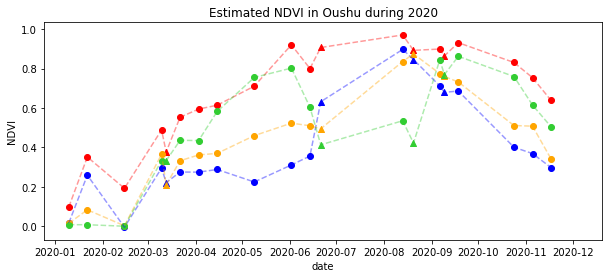

In [214]:
plt.figure(figsize=(10,4))
for ndvi_list, marker, c in zip([ndvi_list1, ndvi_list2, ndvi_list3, ndvi_list4],['o','^','s','s'],['r','b','orange','limegreen']):
    mod_array = ndvi_list[np.where(type_list=='modis')]
    sen_array = ndvi_list[np.where(type_list=='sentinel')]
    mod_date_array = date_list[np.where(type_list=='modis')]
    sen_date_array = date_list[np.where(type_list=='sentinel')]

    plt.xlim(datetime.datetime(2019,12,25), datetime.datetime(2020,12,20))
    plt.scatter(mod_date_array, mod_array, color=c, marker='o')
    plt.scatter(sen_date_array, sen_array, color=c, marker='^')
    plt.plot(date_list, ndvi_list, linestyle='--', alpha=0.4, color=c)

# plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('NDVI')
plt.title('Estimated NDVI in Oushu during 2020')

Text(0.5, 1.0, 'Comparison between original Modis data and downscaled Modis data')

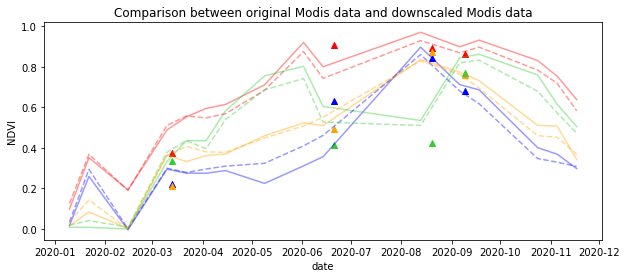

In [213]:
plt.figure(figsize=(10,4))

for ndvi_list, c in zip([ndvi_list1, ndvi_list2, ndvi_list3, ndvi_list4],['r','b','orange','limegreen']):
    mod_array = ndvi_list[np.where(type_list=='modis')]
    mod_date_array = date_list[np.where(type_list=='modis')]
#     plt.scatter(mod_date_array, mod_array, color=c, s=30)
    plt.plot(mod_date_array, mod_array, alpha=0.4, color=c)
    
    sen_array = ndvi_list[np.where(type_list=='sentinel')]
    sen_date_array = date_list[np.where(type_list=='sentinel')]
    plt.scatter(sen_date_array, sen_array, color=c, marker='^')
    

for ndvi_list, c in zip([mod_ndvi_list1, mod_ndvi_list2, mod_ndvi_list3, mod_ndvi_list4],['r','b','orange','limegreen']):
    plt.plot(mod_date_list, ndvi_list, linestyle='--', alpha=0.4, color=c)
#     plt.scatter(mod_date_list, ndvi_list, color=c, marker='x', s=30)
    
plt.xlabel('date')
plt.ylabel('NDVI')
plt.title('Comparison between original Modis data and downscaled Modis data')

## Tsumagoi

In [242]:
# load raw modis data
city = 'tsumagoi'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin_/pixel_resized/*_mod_*.npy')
path_list.sort()

# [405:525, 720:850][85:89, 110:114] = [490:494, 830: 834] # orange
# [350:450, 350:450][59:63, 20:24] = [409:413, 370:374] # blue 
# [100:120, 180:200] -> [110:114, 180:184] # red (mountain)

mod_ndvi_list = []
mod_date_list = []
for path in path_list:
#     print(path)
    img = np.load(path)[0]
    
    idx = path[-8:-4]
    mod_date_list.append(datetime.datetime.strptime('2020'+idx, '%Y%m%d'))
    
    mod_ndvi_list.append(np.mean(img[409:413, 370:374]))
#     plt.imshow(img, vmax=1, vmin=0) #, vmax=1, vmin=0, cmap='jet'
#     plt.show()
    
mod_ndvi_list = np.array(mod_ndvi_list)
mod_date_list = np.array(mod_date_list)

In [209]:
plt.figure(figsize=(10,4))
for ndvi_list, c in zip([mod_ndvi_list1, mod_ndvi_list2, mod_ndvi_list3],['r','b','orange']):
    plt.plot(mod_date_list, ndvi_list, linestyle='--', alpha=0.4, color=c)
    plt.scatter(mod_date_list, ndvi_list, color=c)
    
plt.xlabel('date')
plt.ylabel('NDVI')
plt.title('NDVI from Modis data in Tsumagoi during 2020')

In [568]:
city = 'tsumagoi'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin_/pred_past/pred*.npy')
path_list.sort()

# [405:525, 720:850][85:89, 110:114] = [490:494, 830:834] # orange 
# [350:450, 350:450][59:63, 20:24] = [409:413, 370:374] # blue 
# [100:120, 180:200] -> [110:114, 180:184] # red (mountain)
# [460:464, 825:829] - [466:470, 825:829] # 一毛作違うタイミング?
# 　 - [35:39, 506:510] # １毛 + ２毛
# [132:136, 309:312] # １毛
# [458:462, 262:266] # 無耕作地

type_list = []
ndvi_list = []
date_list = []
for path in path_list:
#     print(path)
    img = np.load(path)
    if '_mod' in path:
        type_list.append('modis')
    elif '_sen':
        type_list.append('sentinel')
    
    idx = path[-12:-8]
    date_list.append(datetime.datetime.strptime('2020'+idx, '%Y%m%d'))
    
    ndvi_list.append(np.mean(img[35:39, 516:520] )) 
#     plt.imshow(img[150:300, 50:250], vmax=1, vmin=0) #, vmax=1, vmin=0, cmap='jet'
#     plt.scatter([115],[102])
#     plt.show()
    
type_list = np.array(type_list)
ndvi_list = np.array(ndvi_list)
date_list = np.array(date_list)

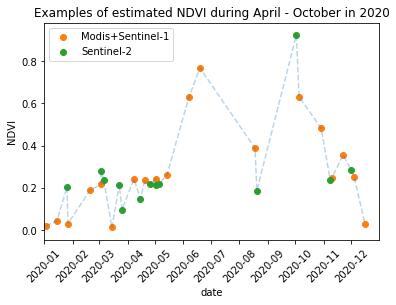

In [286]:
mod_array = ndvi_list[np.where(type_list=='modis')]
sen_array = ndvi_list[np.where(type_list=='sentinel')]
mod_date_array = date_list[np.where(type_list=='modis')]
sen_date_array = date_list[np.where(type_list=='sentinel')]

plt.xlim(datetime.datetime(2020,1,1), datetime.datetime(2020,12,31))
plt.scatter(mod_date_array, mod_array, label='Modis+Sentinel-1', color='C1')
plt.scatter(sen_date_array, sen_array, label='Sentinel-2', color='C2')
plt.plot(date_list, ndvi_list, linestyle='--', alpha=0.3)

plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('NDVI')
plt.title('Examples of estimated NDVI during April - October in 2020')
plt.legend()

## Combine

In [564]:
# load raw modis data
city = 'tsumagoi'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/tmp/*.npy')
path_list.sort()

# [405:525, 720:850][85:89, 110:114] = [490:494, 830: 834] # orange
# [350:450, 350:450][59:63, 20:24] = [409:413, 370:374] # blue 
# [100:120, 180:200] -> [110:114, 180:184] # red (mountain)

mod_ndvi_list = []
mod_date_list = []
for path in path_list:
#     print(path)
    img = np.load(path)
    img = cal_ndvi(img[0], img[1])
    
    idx = path[-9:-5]
    mod_date_list.append(datetime.datetime.strptime('2020'+idx, '%Y%m%d'))
    
    mod_ndvi_list.append(np.mean(img[409:413, 370:374] ))
#     plt.imshow(img, vmax=1, vmin=0) #, vmax=1, vmin=0, cmap='jet'
#     plt.show()
    
mod_ndvi_list = np.array(mod_ndvi_list)
mod_date_list = np.array(mod_date_list)

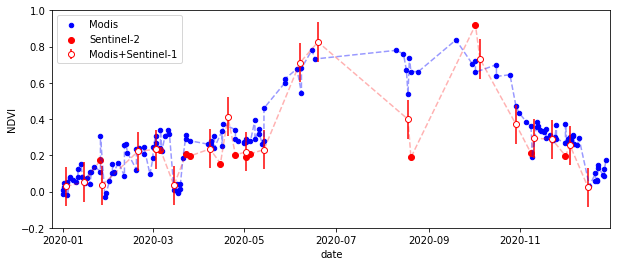

In [565]:
plt.figure(figsize=(10,4))
plt.plot(mod_date_list, mod_ndvi_list, linestyle='--', alpha=0.4, color='blue')
plt.scatter(mod_date_list, mod_ndvi_list, color='blue', label='Modis',s=20)

mod_array = ndvi_list[np.where(type_list=='modis')]
sen_array = ndvi_list[np.where(type_list=='sentinel')]
mod_date_array = date_list[np.where(type_list=='modis')]
sen_date_array = date_list[np.where(type_list=='sentinel')]

plt.xlim(datetime.datetime(2019,12,25), datetime.datetime(2020,12,31))
# plt.scatter(mod_date_array, mod_array, label='Modis+Sentinel-1', color='red')
plt.ylim(-0.2,1)
plt.scatter(sen_date_array, sen_array, label='Sentinel-2', color='red', marker='o')
plt.plot(date_list, ndvi_list, linestyle='--', alpha=0.3, color='red')
plt.errorbar(mod_date_array, mod_array, yerr=[ 0.108 for _ in range(len(mod_date_array))], fmt='o', label='Modis+Sentinel-1', color='red', markerfacecolor='white')
    
plt.xlabel('date')
plt.ylabel('NDVI')
plt.legend(loc='upper left')
# plt.title('NDVI from Modis data in Tsumagoi during 2020')

## Combine2

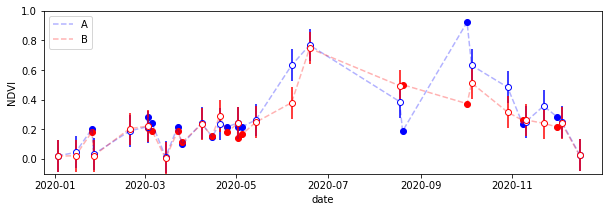

In [570]:
plt.figure(figsize=(10,3))

for ndvi_list,c,label in zip([ndvi_list2, ndvi_list1], ['blue','red'],['A','B']):
    mod_array = ndvi_list[np.where(type_list=='modis')]
    sen_array = ndvi_list[np.where(type_list=='sentinel')]
    mod_date_array = date_list[np.where(type_list=='modis')]
    sen_date_array = date_list[np.where(type_list=='sentinel')]

    # plt.scatter(mod_date_array, mod_array, label='Modis+Sentinel-1', color='red')
    plt.scatter(sen_date_array, sen_array, color=c, marker='o')
    plt.plot(date_list, ndvi_list, linestyle='--', alpha=0.3, color=c, label=label)
    plt.errorbar(mod_date_array, mod_array, yerr=[ 0.108 for _ in range(len(mod_date_array))], fmt='o', color=c, markerfacecolor='white')
    
plt.xlim(datetime.datetime(2019,12,25), datetime.datetime(2020,12,31))    
plt.ylim(-0.1,1)
plt.xlabel('date')
plt.ylabel('NDVI')
plt.legend(loc='upper left')
# plt.title('NDVI from Modis data in Tsumagoi during 2020')

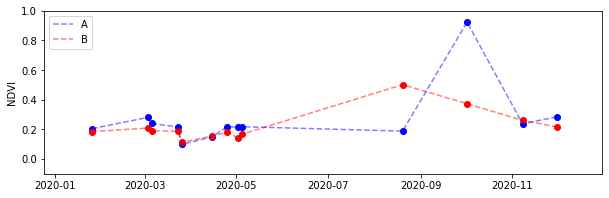

In [290]:
plt.figure(figsize=(10,3))
for ndvi, c, label in zip([ndvi_list2, ndvi_list1], ['blue', 'red'], ['A', 'B']):
    sen_array = ndvi[np.where(type_list=='sentinel')]
    sen_date_array = date_list[np.where(type_list=='sentinel')]
    
    plt.scatter(sen_date_array, sen_array, color=c)
    plt.plot(sen_date_array, sen_array, color=c, label=label, linestyle='--', alpha=0.5)
    
plt.xlim(datetime.datetime(2019,12,25), datetime.datetime(2020,12,31))    
plt.ylim(-0.1,1)
plt.ylabel('NDVI')
plt.legend(loc='upper left')

## With snow

In [75]:
df_snow = pd.read_csv('../sar_2_ndvi/tsumagoi/tsumagoi_snow.csv', encoding="shift-jis")

In [92]:
date_array = []
snow_array = []

for i, row in df_snow.iterrows():
    date_array.append(datetime.datetime.strptime(str(row['年月日']), '%Y/%m/%d'))
    snow_array.append(row['降雪量合計(cm)'])

Text(0, 0.5, 'Observed snowfall [cm]')

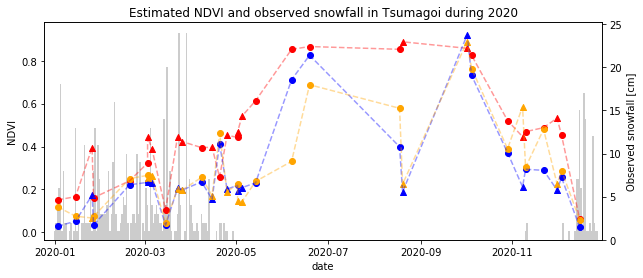

In [284]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

ax2.bar(date_array, snow_array, alpha=0.4, color='grey')


for ndvi_list, marker, c in zip([ndvi_list1, ndvi_list2, ndvi_list3],['o','^','s'],['r','b','orange']):
    mod_array = ndvi_list[np.where(type_list=='modis')]
    sen_array = ndvi_list[np.where(type_list=='sentinel')]
    mod_date_array = date_list[np.where(type_list=='modis')]
    sen_date_array = date_list[np.where(type_list=='sentinel')]

    ax1.set_xlim(datetime.datetime(2019,12,25), datetime.datetime(2020,12,31))
    ax1.scatter(mod_date_array, mod_array, color=c, marker='o')
    ax1.scatter(sen_date_array, sen_array, color=c, marker='^')
    ax1.plot(date_list, ndvi_list, linestyle='--', alpha=0.4, color=c)

ax1.set_xlabel('date')
ax1.set_ylabel('NDVI')
ax1.set_title('Estimated NDVI and observed snowfall in Tsumagoi during 2020')

ax2.set_ylabel('Observed snowfall [cm]')

## Comparison with raw modis

Text(0.5, 1.0, 'Comparison between original Modis data and downscaled Modis data')

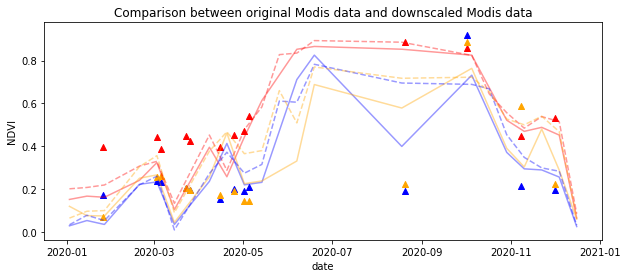

In [410]:
plt.figure(figsize=(10,4))

for ndvi_list, c in zip([ndvi_list1, ndvi_list2, ndvi_list3],['r','b','orange']):
    mod_array = ndvi_list[np.where(type_list=='modis')]
    mod_date_array = date_list[np.where(type_list=='modis')]
#     plt.scatter(mod_date_array, mod_array, color=c, s=30)
    plt.plot(mod_date_array, mod_array, alpha=0.4, color=c)
    
    sen_array = ndvi_list[np.where(type_list=='sentinel')]
    sen_date_array = date_list[np.where(type_list=='sentinel')]
    plt.scatter(sen_date_array, sen_array, color=c, marker='^')
    

for ndvi_list, c in zip([mod_ndvi_list1, mod_ndvi_list2, mod_ndvi_list3],['r','b','orange']):
    plt.plot(mod_date_list, ndvi_list, linestyle='--', alpha=0.4, color=c)
#     plt.scatter(mod_date_list, ndvi_list, color=c, marker='x', s=30)
    
plt.xlabel('date')
plt.ylabel('NDVI')
plt.title('Comparison between original Modis data and downscaled Modis data')

# Normalized NDVI

## Calculate factor from 2020 data

In [55]:
def calculate_factors(mod_r, mod_ir, sen_ndvi):
    min_loss = float('inf')
    argmin_loss = []
    for r_fac in np.arange(0, 1.2, 0.01):
        for ir_fac in np.arange(0, 1.2, 0.01):
            mod_ndvi = (mod_ir * ir_fac - mod_r * r_fac) / (mod_ir * ir_fac + mod_r * r_fac + (1e-7))
            loss = mean_absolute_error(np.ravel(mod_ndvi), np.ravel(sen_ndvi))
            if loss < min_loss:
                argmin_loss = [r_fac, ir_fac]
                min_loss = loss
    return argmin_loss

In [56]:
sen_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204']
mod_idx_list = ['0126','0303','0425','0502','0820','1002','1108','1201']

r_fac_list = []
ir_fac_list = []
for sen_idx, mod_idx in zip(sen_idx_list, mod_idx_list):
    mod = np.load(f'../sar_2_ndvi/tsumagoi/modis_ensemble/bin/ensemble_r_ir/collocate_{mod_idx}.npy')
    mod_r = drop_resolution(mod[0])[0]
    mod_ir = drop_resolution(mod[1])[0]
    
    sen = np.load(f'../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_{sen_idx}.npy')
    sen = drop_resolution(cal_ndvi(sen[4], sen[5]))[0]
    
    fac_list = calculate_factors(mod_r, mod_ir, sen)
    r_fac_list.append(fac_list[0])
    ir_fac_list.append(fac_list[1])
print(np.mean(r_fac_list), np.mean(ir_fac_list))

0.83375 0.77875


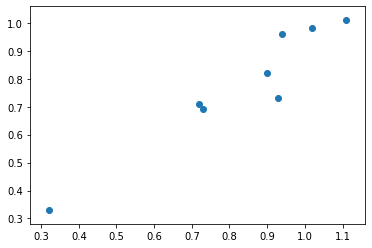

In [62]:
plt.scatter(r_fac_list, ir_fac_list)

In [59]:
sen_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204']
mod_idx_list = ['0126','0303','0425','0502','0820','1002','1108','1201']

mae_list = []
for sen_idx, mod_idx in zip(sen_idx_list, mod_idx_list):
    mod = np.load(f'../sar_2_ndvi/tsumagoi/modis_ensemble/bin/ensemble_r_ir/collocate_{mod_idx}.npy')
#     mod_ndvi = cal_ndvi(mod[0], mod[1])
    mod_ndvi = (mod[1] * np.mean(ir_fac_list) - mod[0] * np.mean(r_fac_list)) / (mod[1] * np.mean(ir_fac_list) + mod[0] * np.mean(r_fac_list) + (1e-7))
    mod_ndvi = drop_resolution(mod_ndvi)[0]
    
    
    sen = np.load(f'../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_{sen_idx}.npy')
    sen_ndvi = drop_resolution(cal_ndvi(sen[4], sen[5]))[0]
    
    mae_list.append(mean_absolute_error(sen_ndvi, mod_ndvi))
print(np.mean(mae_list))

0.05703877828217918


# Second crop detection

In [571]:
img6_1 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0607_mod.npy')
img6_2 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0619_mod.npy')

img8_1 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0818_mod.npy')
img8_2 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0820_sen.npy')[:525,:965]

img10_1 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_1002_sen.npy')[:525,:965]
img10_2 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_1005_mod.npy')

img_6 = (img6_1 + img6_2) /2
img_8 = (img8_1 + img8_2) /2
img_10 = (img10_1 + img10_2) /2

img = (img_6 + img_10)/2 - img_8 # second crop
# img = (img_6+img_8+img_10)/3

In [537]:
# 4 -> crops
land_cover_map = np.load('../sar_2_ndvi/tsumagoi/land_cover/land_cover.npy')[0][:525,:965]
land_cover_mask = np.where(land_cover_map==4, 1, np.nan)

In [538]:
img = img * land_cover_mask

(-0.5, 964.5, 524.5, -0.5)

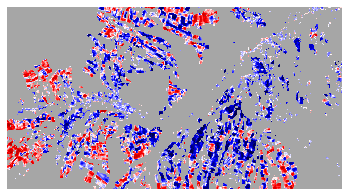

In [548]:
current_cmap = matplotlib.cm.get_cmap('seismic_r')
current_cmap.set_bad(color='grey', alpha=0.7)

plt.imshow(img, vmin=-0.5, vmax=0.5, cmap=current_cmap)# [280:530,600:850]
plt.axis('off')
# plt.colorbar(orientation='horizontal', aspect=40)

# Land cover classification

In [576]:
img6_1 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0607_mod.npy')
img6_2 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0619_mod.npy')

img8_1 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0818_mod.npy')
img8_2 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_0820_sen.npy')[:525,:965]

img10_1 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_1002_sen.npy')[:525,:965]
img10_2 = np.load('../sar_2_ndvi/tsumagoi/time_series/bin_/pred_past/pred_1005_mod.npy')

img_6 = (img6_1 + img6_2) /2
img_8 = (img8_1 + img8_2) /2
img_10 = (img10_1 + img10_2) /2

sec = (img_6 + img_10)/2 - img_8 # second crop
no = (img_6+img_8+img_10)/3

In [613]:
img_rgb = np.zeros((525, 965, 3))
threshold = 0.65
r_multiple = 0.5
gb_multiple = 1

for i in range(img_rgb.shape[0]):
    for j in range(img_rgb.shape[1]):
        r = (1 + sec[i][j])/2 * r_multiple
        if no[i][j] - threshold > 0:
            g = no[i][j] - threshold
            b = 0
        else:
            b = - (no[i][j] - threshold)
            g = 0
            
        img_rgb[i][j][0] = r
        img_rgb[i][j][1] = g
        img_rgb[i][j][2] = b

In [606]:
def abc_to_rgb(A=0.0,B=0.0,C=0.0):
    ''' Map values A, B, C (all in domain [0,1]) to
    suitable red, green, blue values.'''
    return (min(A,1.0),min(B,1.0),min(C,1.0))

def plot_legend():
    ''' Plots a legend for the colour scheme
    given by abc_to_rgb. Includes some code adapted
    from http://stackoverflow.com/a/6076050/637562'''

    # Basis vectors for triangle
    basis = np.array([[0.0, 1.0], [-1.5/np.sqrt(3), -0.5],[1.5/np.sqrt(3), -0.5]])

    fig = plt.figure()
    ax = fig.add_subplot(111,aspect='equal')

    # Plot points
    a, b, c = np.mgrid[0.0:1.0:50j, 0.0:1.0:50j, 0.0:1.0:50j]
    a, b, c = a.flatten(), b.flatten(), c.flatten()

    abc = np.dstack((a,b,c))[0]
#     abc = list(filter(lambda x: x[0]+x[1]+x[2]==1, abc)) # remove points outside triangle
    abc = list(map(lambda x: x/sum(x), abc)) # or just make sure points lie inside triangle ...

    data = np.dot(abc, basis)
    colours = [abc_to_rgb(A=point[0],B=point[1],C=point[2]) for point in abc]

    ax.scatter(data[:,0], data[:,1],marker=',',edgecolors='none',facecolors=colours)

    # Plot triangle
    for i in range(3):
        ax.plot([basis[i-1,0],basis[i,0]],[basis[i-1,1],basis[i,1]],**{'color':'black','linewidth':3})

    # Plot labels at vertices
    offset = 0.25
    fontsize = 32
#     ax.text(basis[0,0]*(1+offset), basis[0,1]*(1+offset), '$A$', horizontalalignment='center',
#             verticalalignment='center', fontsize=fontsize)
#     ax.text(basis[1,0]*(1+offset), basis[1,1]*(1+offset), '$B$', horizontalalignment='center',
#             verticalalignment='center', fontsize=fontsize)
#     ax.text(basis[2,0]*(1+offset), basis[2,1]*(1+offset), '$C$', horizontalalignment='center',
#             verticalalignment='center', fontsize=fontsize)    

    ax.set_frame_on(False)
    ax.set_xticks(())
    ax.set_yticks(())

    plt.show()

/Users/ryotanomura/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


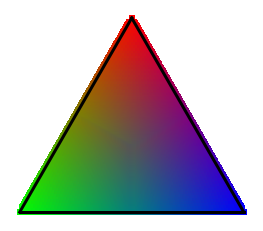

In [607]:
plot_legend()

# Generate GIF

In [126]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

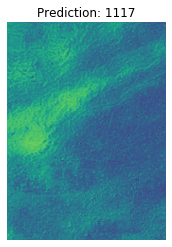

In [218]:
city = 'oushu'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin/pred/pred*.npy')
path_list.sort()

for path in path_list:
    date_str = path[-12:-8]
    if 'mod' in path:
        plt.title(f'Prediction: {date_str}')
    elif 'sen' in path:
        plt.title(f'Sentinel-2: {date_str}')
    plt.imshow(np.load(path)[:885, :645], vmin=0, vmax=1)
    plt.axis('off')
    plt.savefig(path.replace('pred', 'img_gif').replace('.npy', '.png'), bbox_inches='tight')

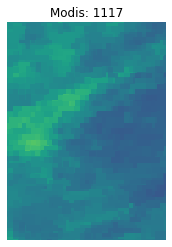

In [224]:
city = 'oushu'
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin/pixel_resized_/input/collocate_*.npy')
path_list.sort()

for path in path_list:
    date_str = path[-8:-4]
    plt.title(f'Modis: {date_str}')
    plt.imshow(np.load(path)[0][:885, :645], vmin=0, vmax=1)
    plt.axis('off')
    plt.savefig(path.replace('pixel_resized_/input', 'img_gif').replace('.npy', '.png'), bbox_inches='tight')

In [197]:
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred*.png')
path_list.sort()
date_str_list = [path[-12:-8] for path in path_list]
name_list =  [path[-17:] for path in path_list]

sen_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_nodata.png')# .convert('RGB')
mod_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_nodata.png')# .convert('RGB')
mod_raw_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_nodata.png')# .convert('RGB')

imgs = []
img_flag = ''
for date_str in date_str_list:
    if f'pred_{date_str}_mod.png' in name_list:
        mod_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_{date_str}_mod.png')# .convert('RGB')
        mod_raw_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/collocate_mod_{date_str}.png')# .convert('RGB')
        img_flag = 'mod'
    if f'pred_{date_str}_sen.png' in name_list:
        sen_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_{date_str}_sen.png')# .convert('RGB')
        img_flag = 'sen'
    
    img = get_concat_h(sen_img, mod_raw_img)
    img = get_concat_h(img, mod_img)
    
    if img_flag == 'sen':
        draw = ImageDraw.Draw(img)
        draw.ellipse((100, 7, 110, 17), fill=(255,0,0))
    elif img_flag == 'mod':
        draw = ImageDraw.Draw(img)
        draw.ellipse((449, 7, 459, 17), fill=(255,0,0))
        draw.ellipse((798, 7, 808, 17), fill=(255,0,0))
        
    imgs.append(img)
    img.save(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/combined/pred_{date_str}.png')

In [163]:
imgs[0].save(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/combined/pred_h.gif', save_all=True, append_images=imgs[1:], optimize=False, duration=300, loop=0)

In [131]:
# For double
path_list = glob.glob(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred*.png')
path_list.sort()
date_str_list = [path[-12:-8] for path in path_list]
name_list =  [path[-17:] for path in path_list]

sen_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_nodata.png')# .convert('RGB')
mod_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_nodata.png')# .convert('RGB')
mod_raw_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_nodata.png')# .convert('RGB')

imgs = []
img_flag = ''
for date_str in date_str_list:
    if f'pred_{date_str}_mod.png' in name_list:
        mod_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_{date_str}_mod.png')# .convert('RGB')
        mod_raw_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/collocate_mod_{date_str}.png')# .convert('RGB')
        img_flag = 'mod'
    if f'pred_{date_str}_sen.png' in name_list:
        sen_img = Image.open(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/pred_{date_str}_sen.png')# .convert('RGB')
        img_flag = 'sen'
    
    img = get_concat_h(mod_raw_img, mod_img)
    
    if img_flag == 'mod':
        imgs.append(img)
        img.save(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/double/pred_{date_str}.png')

In [133]:
imgs[0].save(f'../sar_2_ndvi/{city}/time_series/bin_/img_gif/double/pred_h.gif', save_all=True, append_images=imgs[1:], optimize=False, duration=300, loop=0)